## The PGM
For more an introduction to PGMS see Daphne Koller's [Probabilistic Graphical Models](http://pgm.stanford.edu/). Below is the PGM that we will explore in this notebook.

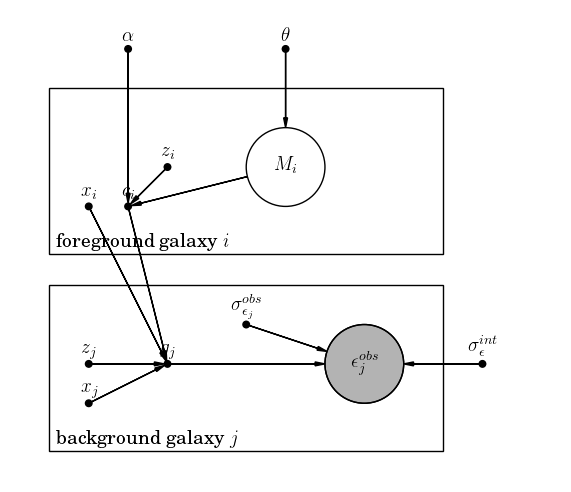

In [1]:
%matplotlib inline

from matplotlib import rc
rc("font", family="serif", size=14)
rc("text", usetex=True)

import daft

pgm = daft.PGM([7, 6], origin=[0, 0])

#background nodes
pgm.add_plate(daft.Plate([0.5, 3.0, 5, 2], label=r"foreground galaxy $i$",
    shift=-0.1))
pgm.add_node(daft.Node("theta", r"$\theta$", 3.5, 5.5, fixed=True))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 1.5, 5.5, fixed=True))
pgm.add_node(daft.Node("halo_mass", r"$M_i$", 3.5, 4, scale=2))
pgm.add_node(daft.Node("background_z", r"$z_i$", 2, 4, fixed=True))
pgm.add_node(daft.Node("concentration", r"$c_i$", 1.5, 3.5, fixed=True))
pgm.add_node(daft.Node("background_x", r"$x_i$", 1.0, 3.5, fixed=True))

#foreground nodes
pgm.add_plate(daft.Plate([0.5, 0.5, 5, 2], label=r"background galaxy $j$",
    shift=-0.1))
pgm.add_node(daft.Node("reduced_shear", r"$g_j$", 2.0, 1.5, fixed=True))
pgm.add_node(daft.Node("reduced_shear", r"$g_j$", 2.0, 1.5, fixed=True))
pgm.add_node(daft.Node("foreground_z", r"$z_j$", 1.0, 1.5, fixed=True))
pgm.add_node(daft.Node("foreground_x", r"$x_j$", 1.0, 1.0, fixed=True))
pgm.add_node(daft.Node("ellipticities", r"$\epsilon_j^{obs}$", 4.5, 1.5, observed=True, scale=2))

#outer nodes
pgm.add_node(daft.Node("sigma_obs", r"$\sigma_{\epsilon_j}^{obs}$", 3.0, 2.0, fixed=True))
pgm.add_node(daft.Node("sigma_int", r"$\sigma_{\epsilon}^{int}$", 6.0, 1.5, fixed=True))

#edges
pgm.add_edge("foreground_z", "reduced_shear")
pgm.add_edge("foreground_x", "reduced_shear")
pgm.add_edge("reduced_shear", "ellipticities")
pgm.add_edge("sigma_obs", "ellipticities")
pgm.add_edge("sigma_int", "ellipticities")
pgm.add_edge("concentration", "reduced_shear")
pgm.add_edge("halo_mass", "concentration")
pgm.add_edge("background_z", "concentration")
pgm.add_edge("background_x", "reduced_shear")
pgm.add_edge("alpha", "concentration")
pgm.add_edge("theta", "halo_mass")
pgm.render()

We have sets of foregrounds and backgrounds along with the variables

- $\alpha$:  parameters in the concentration function (which is a function of $z_i,M_i$)
- $\theta$: prior distribution of halo masses
- $z_i$: foreground galaxy redshift
- $x_i$: foreground galaxy angular coordinates
- $z_j$: background galaxy redshift
- $x_j$: background galaxy angular coordinates
- $g_j$: reduced shear
- $\sigma_{\epsilon_j}^{obs}$: noise from our ellipticity measurement process
- $\sigma_{\epsilon}^{int}$: intrinsic variance in ellipticities
- $\epsilon_j^{obs}$: intrinsic variance in ellipticities

## Stellar Mass Threshold

In [2]:
from pandas import read_table
from pangloss import GUO_FILE

m_h = 'M_Subhalo[M_sol/h]'
m_s = 'M_Stellar[M_sol/h]'

guo_data = read_table(GUO_FILE)
nonzero_guo_data= guo_data[guo_data[m_h] > 0]

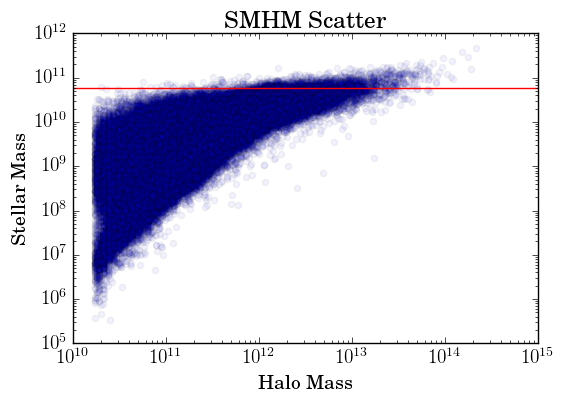

In [5]:
import matplotlib.pyplot as plt

stellar_mass_threshold = 5.883920e+10
plt.scatter(nonzero_guo_data[m_h], nonzero_guo_data[m_s], alpha=0.05)
plt.axhline(y=stellar_mass_threshold, color='red')
plt.xlabel('Halo Mass')
plt.ylabel('Stellar Mass')
plt.title('SMHM Scatter')
plt.xscale('log')
plt.yscale('log')

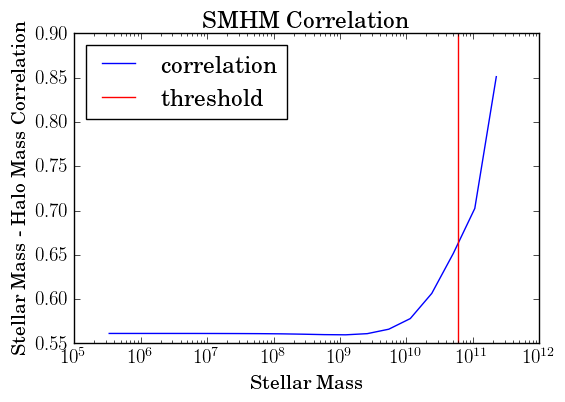

In [7]:
from math import log
import numpy as np

start = log(nonzero_guo_data[m_s].min(), 10)
stop = log(nonzero_guo_data[m_s].max(), 10)

m_logspace = np.logspace(start, stop, num=20, base=10)[:-1]

m_corrs = []
thin_data = nonzero_guo_data[[m_s, m_h]]
for cutoff in m_logspace:
    tmp = thin_data[nonzero_guo_data[m_s] > cutoff]
    m_corrs.append(tmp.corr()[m_s][1])
    
plt.plot(m_logspace, m_corrs, label='correlation')
plt.axvline(x=stellar_mass_threshold, color='red', label='threshold')
plt.xscale('log')
plt.legend(loc=2)
plt.xlabel('Stellar Mass')
plt.ylabel('Stellar Mass - Halo Mass Correlation')
plt.title('SMHM Correlation')

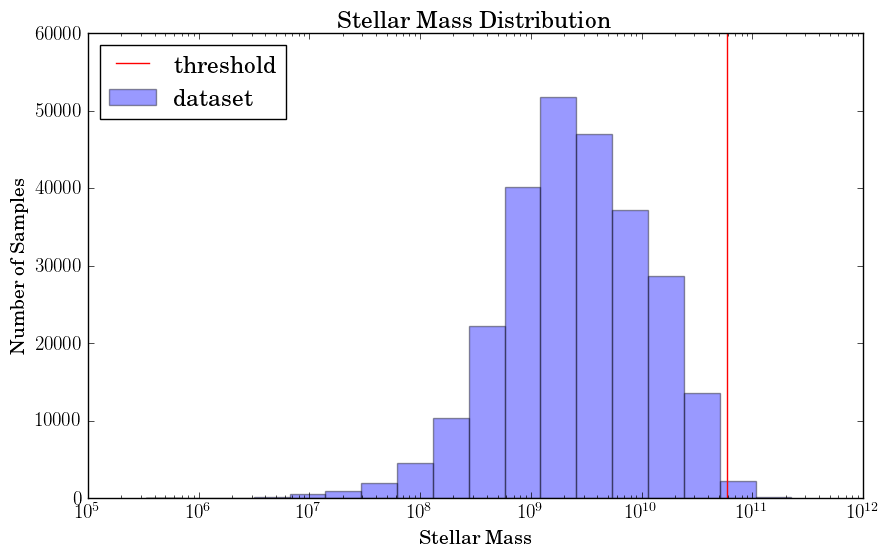

In [8]:
plt.rcParams['figure.figsize'] = (10, 6)
# plt.plot(hist[1][:-1], hist[0], label='correlation')
plt.hist(nonzero_guo_data[m_s], bins=m_logspace, alpha=0.4, normed=False, label='dataset')
plt.axvline(x=stellar_mass_threshold, color='red', label='threshold')
plt.xscale('log')
plt.legend(loc=2)
plt.xlabel('Stellar Mass')
plt.ylabel('Number of Samples')
plt.title('Stellar Mass Distribution')

## Results

In [60]:
from pandas import read_csv

res = read_csv('data3.csv')
tru = read_csv('true3.csv')

In [61]:
start = min([res[res[c] > 0][c].min() for c in res.columns[1:-1]])
stop = res.max().max()

In [62]:
base = 10
start = log(start, base)
end = log(stop, base)
res_logspace = np.logspace(start, end, num=10, base=base)

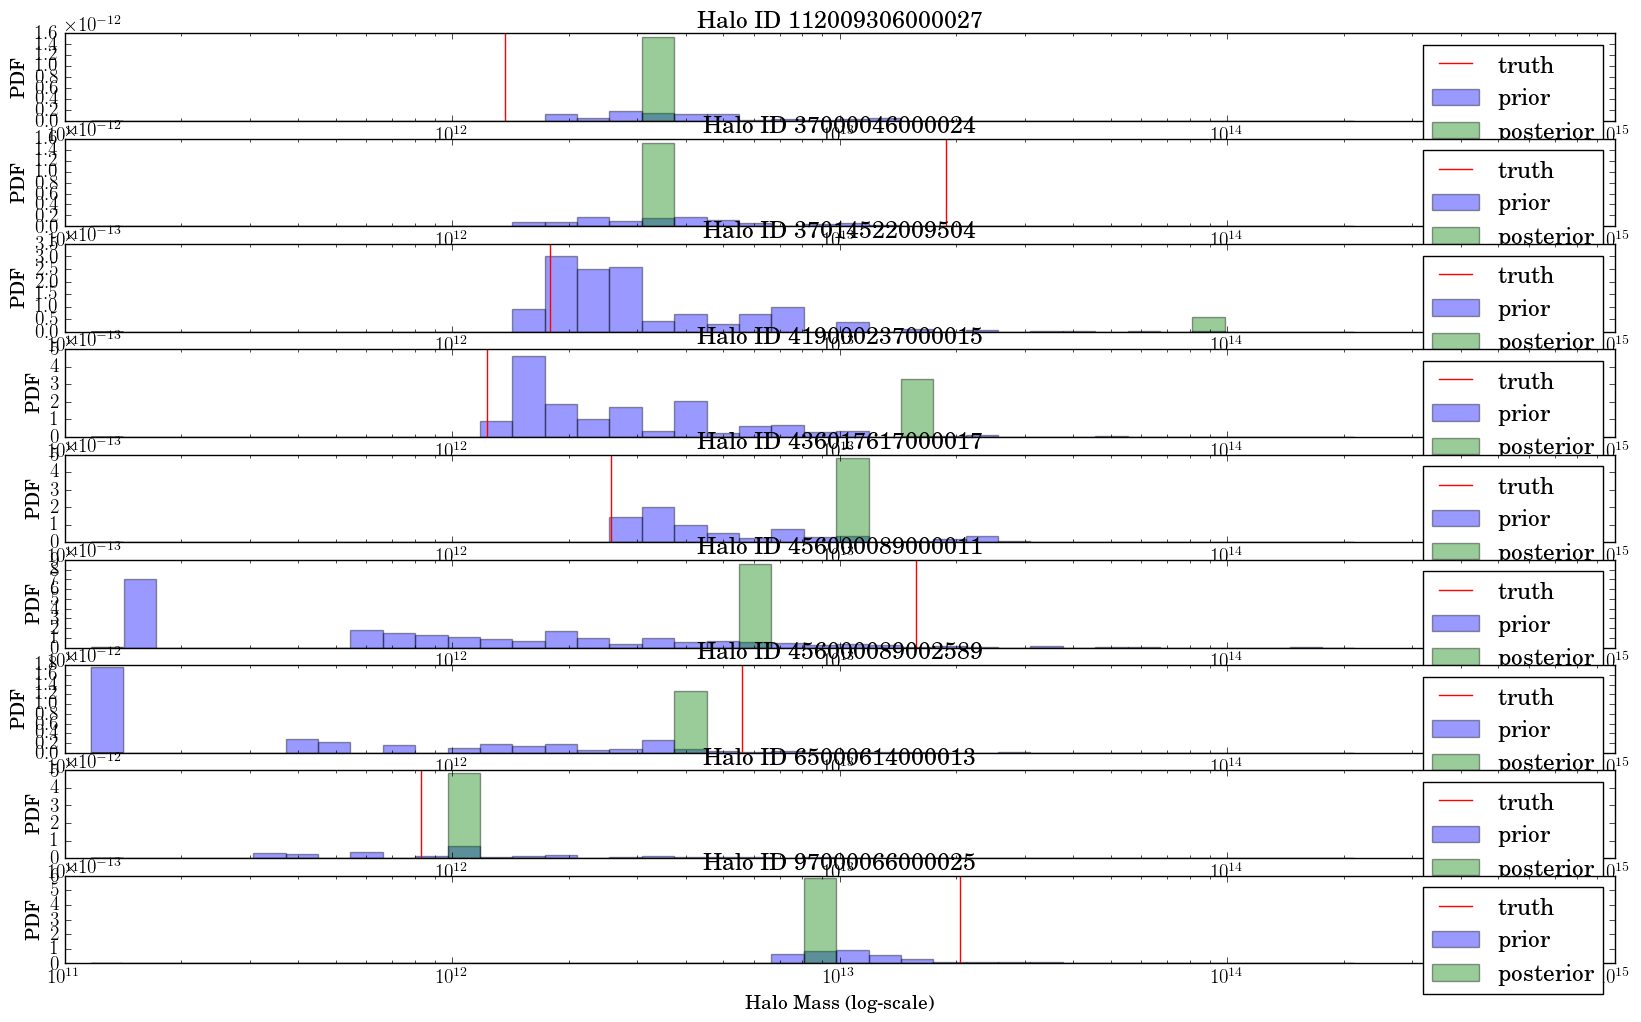

In [63]:
plt.rcParams['figure.figsize'] = (20, 12)

for i,val in enumerate(tru.columns[1:]):
    plt.subplot(int('91' + str(i+1)))
    x = res[val][res[val] > 0]
    weights = np.exp(res['log-likelihood'][res[val] > 0])
    t = tru[val].loc[0]
    plt.hist(x, bins=res_logspace, alpha=0.4, normed=True, label='prior')
    plt.hist(x, bins=res_logspace, weights=weights, alpha=0.4, normed=True, label='posterior')
    plt.axvline(x=t, color='red', label='truth', linewidth=1)
    plt.xscale('log')
    plt.legend()
    plt.ylabel('PDF')
    plt.xlabel('Halo Mass (log-scale)')
    plt.title('Halo ID ' + val)
    
plt.show()

In [52]:
res.columns

Index([u'Unnamed: 0', u'112009306000027', u'37000046000024', u'37014522009504',
       u'419000237000015', u'436017617000017', u'456000089000011',
       u'456000089002589', u'65000614000013', u'74004925000017',
       u'82020319006828', u'97000066000025', u'log-likelihood'],
      dtype='object')

In [57]:
res[['112009306000027', 'log-likelihood']].sort('log-likelihood')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,112009306000027,log-likelihood
977,8.576450e+12,-178.423575
986,1.501850e+13,-178.183221
985,-1.000000e+00,-178.124869
975,1.488250e+13,-178.044443
987,1.779580e+13,-178.024270
978,-1.000000e+00,-178.020655
980,1.150700e+13,-177.748564
974,9.686690e+12,-177.729791
976,-1.000000e+00,-177.704476
988,7.191650e+12,-177.587342


## Next Steps

#### Move forward with major software upgrades
- Flying blind, guessing what will be important in future
- Add importance sampling
- Reduce duplication
- Parallelize
- Slowly transition code base to better software practices
- Eliminate prototype code that is not core to module
- At some point it becomes cheaper to rewrite code with high parallelization and good software practices instead of hacking in extra functinality to code that is poorly suited to our goal

#### Pivot to new question/milestone
- Shrink foreground
- See if results improve with 'unphysical', dense background
- Hit the literature to see what questions have been answered and get ideas for cool project directions
- Thanks Warren for pointing me to resources for learning weak lensing